# Градиентные методы

## Vanilla Gradient

### Идея метода

Имея информацию о структуре модели, можно использовать градиент, чтобы понять, как входы связаны с выходом.

Градиент указывает направление возрастания функции. Если мы выберем  **logit, соответствующий метке наиболее вероятного класса**, и посчитаем для него **градиент по исходному изображению**, мы можем узнать, какие пиксели нужно “усилить”, чтобы модель была более уверена в ответе.

<center><img src ="https://edunet.kea.su/repo/EduNet-additions/GM/saliency_via_backprop.png" width="800">

<em>Source: <a href="https://arxiv.org/pdf/1312.6034.pdf">Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps
</a></em></center>

Тут важно заметить, что пример из статьи на картинке выше — это **cherry picked** (специально отобранный пример, для которого данный метод дает хороший результат). Давайте посмотрим на нашей картинке.

###Пример изображения (ResNet18)

Загрузим изображение

In [ ]:
!wget -q 'https://edunet.kea.su/repo/EduNet-additions/GM/cat_and_dog1.jpg' -O cat_and_dog1.jpg
!wget -q 'https://edunet.kea.su/repo/EduNet-additions/GM/imagenet_class_index.json' -O imagenet_class_index.json

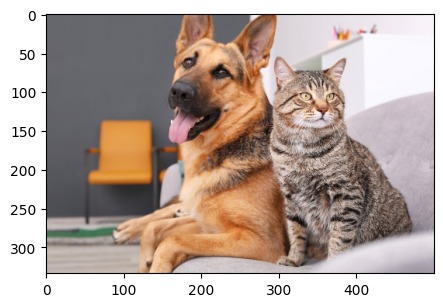

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image


def get_image(path):
    with open(os.path.abspath(path), "rb") as f:
        with Image.open(f) as img:
            return img.convert("RGB")


img = get_image("cat_and_dog1.jpg")
plt.rcParams["figure.figsize"] = (5, 5)
plt.imshow(img)
plt.show()

Теперь нам нужно преобразовать это изображение в тензор PyTorch, а также нормализовать его для использования в нашей предварительно обученной модели.

In [ ]:
from torchvision import transforms

# resize & normalize
def get_input_transform():
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        )
    ])
    return transform

# for get croped img from input tensor
def get_reverse_transform():
    transform = transforms.Compose([
        transforms.Normalize(
            mean=(0., 0., 0.),
            std=(1/0.229, 1/0.224, 1/0.225)
        ),
        transforms.Normalize(
            mean=(-0.485, -0.456, -0.406),
            std=(1., 1., 1.),
        ),
        transforms.Lambda(
            lambda x: torch.permute(x, (0, 2, 3, 1))
        ),
        transforms.Lambda(
            lambda x: x.detach().numpy()
        ),
    ])
    return transform

def get_input_tensors(img):
    transform = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transform(img).unsqueeze(0)

def get_crop_img(img_tensor):
    transform = get_reverse_transform()
    return transform(img_tensor)[0]


Загрузим предобученную модель ResNet18, доступную в PyTorch, и классы изображений из ImageNet.

In [ ]:
import torch
from torchvision import models
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")

idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath("/content/imagenet_class_index.json"), "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    lable2idx = {class_idx[str(k)][1]: k for k in range(len(class_idx))}

Получим предсказание. А после этого полученные нами прогнозы (logits) пропустим через softmax, чтобы получить вероятности и метки классов для 6 лучших прогнозов.

In [ ]:
print(type(img))
img_t = get_input_tensors(img)

model.to(device)
model.eval()
logits = model(img_t.to(device))

<class 'PIL.Image.Image'>


In [ ]:
import torch.nn.functional as F


def top_k_class(logits, k=6):
    prediction = F.softmax(logits, dim=1)
    top_props, top_inds = prediction.topk(k)

    for i in range(k):
        category_name = idx2label[top_inds[0][i].item()]
        score = top_props[0][i].item()
        print(f"{category_name} {top_inds[0][i].item()}: {100 * score:.1f}%")

top_k_class(logits)

German_shepherd 235: 40.3%
tabby 281: 9.5%
tiger_cat 282: 6.9%
Egyptian_cat 285: 2.7%
space_heater 811: 2.3%
malinois 225: 1.2%


Включаем расчет градиента для изображения. Делаем предсказание. Выбираем наиболее вероятный logit.

In [ ]:
img_t.requires_grad = True  # Tell pytorch to compute grads w.r.t. inputs too

logits = model(img_t.to(device))  # [1,1000] batch of one element, 1000 class scores
top_score, top_idx = logits[0].topk(1)  # Get id of class with best score
id = top_idx[0].item()

print(id, idx2label[id])  # Print the label this class

score = logits[:, id]  # Model output for particular class

235 German_shepherd


Для выхода модели, соответствующего нашему классу, рассчитываем градиент.

In [ ]:
# Compute gradients
score.backward(retain_graph=True)

# retain_grad = True is not nessesary
# But if we run this code second time, we got a torch error without it
# because pytorch want to accumulate gradients explicitly

print(img_t.grad.shape)

torch.Size([1, 3, 224, 224])


У входного тензора (изображения) появился градиент, который указывает на то, как каждый элемент повлиял на выход модели. Отобразим этот градиент.

In [ ]:
import numpy as np
from matplotlib import pylab as P


# Helper method to display grad
def grad_to_image(raw_grads, percentile=99):
    gradients = raw_grads.detach().cpu().numpy()
    gradients = np.transpose(gradients, (0, 2, 3, 1))[0]

    image_2d = np.sum(np.abs(gradients), axis=2)

    vmax = np.percentile(image_2d, percentile)
    vmin = np.min(image_2d)

    return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1)


def plot_saliency_map(img_tensor, saliency_map):
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.subplot(1, 2, 1)
    img = get_crop_img(img_t)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap=P.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

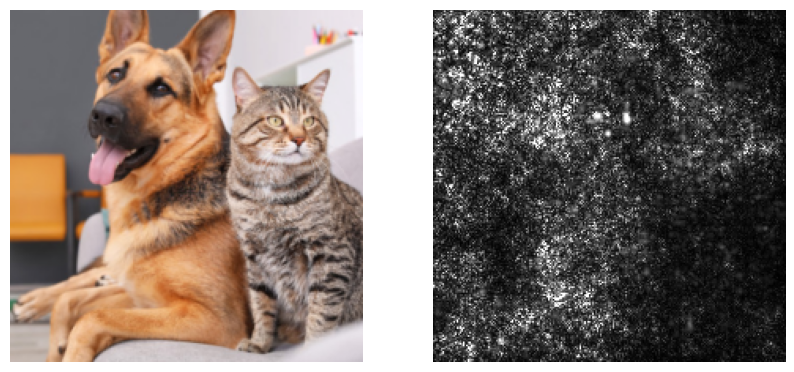

In [ ]:
saliency_map = grad_to_image(img_t.grad)
plot_saliency_map(img_t, saliency_map)

**Карта важности (saliency map)**, полученная таким образом, получается очень зашумленной.

### Проблема насыщения (saturation)

Одним из недостатков **карты важности** (saliency map), полученной методом **Vanilla Gradient**, является **проблема насыщения** (saturation). Простыми словами эту проблему можно сформулировать так: если какой-то **признак “идеально” характеризует объект**, как принадлежащий к определенному классу, то **градиент** этого признака по логиту этого класса **будет нулевым**. То есть **Vanilla Gradient** будет **занижать важность очень хороших признаков**.

## SmoothGrad


### Идея метода

Проблемой Vanilla Gradient Ascent является большая зашумленность карты важности. Было придумано несколько способов борьбы с этим, один из них был предложен в статье [SmoothGrad: removing noise by adding noise](https://arxiv.org/pdf/1706.03825.pdf).

Как вы можете догадаться из названия статьи, идея **SmoothGrad** заключается в **добавлении** к исходному изображению $x$ **гауссовского шума**:

$$\large x+\mathcal{N}(0, \sigma^2).$$

Для набора зашумленных изображений с помощью **Vanilla Gradient** рассчитываются **карты важности (saliency map)**:

$$\large M_c(x+\mathcal{N}(0, \sigma^2)).$$

**Карты важности**, полученные от зашумленных изображений, **усредняются**:

$$\large SmoothGrad = \frac{1}{n}\sum_{1}^{n}M_c(x+\mathcal{N}(0, \sigma^2)),$$

$SmoothGrad$ — результат SmoothGrad.






<center><img src ="https://edunet.kea.su/repo/EduNet-additions/GM/smooth_grad.png" width="800">

<em>Source: <a href="https://arxiv.org/pdf/1706.03825.pdf">SmoothGrad: removing noise by adding noise
</a></em></center>


В статье рекомендуют выбирать $n = 50$ и 10–20% шума. Уровень шума определяют как отношение:

$$\large \frac{\sigma}{x_{max}-x_{min}}.$$

SmoothGrad частично решает проблему насыщения, “раскачивая” хорошие признаки.

###Пример изображения (ResNet18)

Для визуализации работы SmoothGrad используем [код](https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb) c [сайта](https://pair-code.github.io/saliency/), посвященного [статье](https://arxiv.org/pdf/1706.03825.pdf).

In [ ]:
from IPython.display import clear_output


!pip install saliency

clear_output()

У кода есть особенность: нужно написать функцию `call_model_function`, вызывающую модель.

При этом любое изображение, поданное в метод `GetMask` класса `GradientSaliency`, будет преобразовано в `np.array`. К тому же, размер входного изображения и размер карты важности на выходе должны совпадать, что осложняет использование `torchvision.transforms`.

In [ ]:
import saliency.core as saliency
import numpy as np
from PIL import Image


model = models.resnet18(weights="ResNet18_Weights.DEFAULT")

def call_model_function(img, call_model_args=None, expected_keys=None):
    img_t = torch.tensor(np.transpose(img, (0, 3, 1, 2)))
    transform = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    img_t = transform(img_t)
    img_t.requires_grad_(True)

    model.to(device)
    model.eval()
    logits = model(img_t.float().to(device))

    top_score, top_idx = logits[0].topk(1)  # Get id of class with best score
    target_class_idx = top_idx[0].item()

    output = logits[:, target_class_idx]
    grads = torch.autograd.grad(
        output,
        img_t,
        grad_outputs=torch.ones_like(output)
    ) # output[:, target_class_idx]
    grads = torch.movedim(grads[0], 1, 3)
    gradients = grads.detach().numpy()
    return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

Получаем Vanilla Gradient, рассчитанный для исходного изображения с помощью установленной библиотеки, и результат  SmoothGrad.

In [ ]:
img = get_image("cat_and_dog1.jpg")
img_t = get_input_tensors(img)
img_arr = get_crop_img(img_t)

gradient_saliency = saliency.GradientSaliency()

vanilla_mask_3d = gradient_saliency.GetMask(img_arr, call_model_function)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(img_arr,
                                                       call_model_function)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

Визуализируем результат:

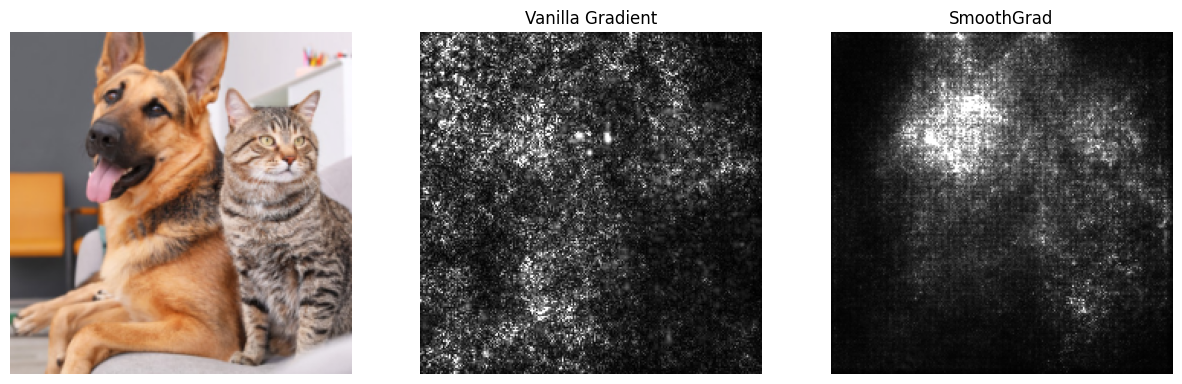

In [ ]:
from matplotlib import pylab as P

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

# Set up matplot lib figures.
plt.rcParams["figure.figsize"] = (15, 5)

plt.subplot(1, 3, 1)
plt.imshow(img_arr)
plt.axis('off')

ShowGrayscaleImage(
    vanilla_mask_grayscale,
    title='Vanilla Gradient',
    ax=P.subplot(1, 3, 2)
)
ShowGrayscaleImage(
    smoothgrad_mask_grayscale,
    title='SmoothGrad',
    ax=P.subplot(1, 3, 3)
)

##Integrated Gradients

### Идея метода

Следующий метод, который мы посмотрим, называется **Integrated Gradients**. Он напоминает **SmoothGrad** тем, что мы намеренно "портим" изображения. Давайте разберемся, как он работает.

В методе **Integrated Gradients** мы выбираем **опорное изображение** $x'$. В качестве опорного изображения используется черный фон (значения каждого пикселя равны $(0,0,0)$ по RGB-каналам). Оцениваемое изображение $x$ примешивают к опорному изображению $x’$ с пропорцией $\alpha$:

$$\large x'+\alpha(x-x')$$

Таким образом мы портим изображение и постепенно его восстанавливаем.

<center><img src ="https://edunet.kea.su/repo/EduNet-additions/GM/IG_fireboat_1.png" width="900">

<em>Source: <a href="https://www.tensorflow.org/tutorials/interpretability/integrated_gradients">Tensorflow tutorials: Integrated gradients
</a></em></center>

Для смеси изображений считается **Vanilla Gradient**:

$$\large M_c(x'+\alpha(x-x'))$$

Формула, лежащая в основе **Integrated Gradients**, была предложена в [статье](https://arxiv.org/pdf/1703.01365.pdf). Это — интегральное значение градиента при восстановлении изображения.

$$\large IntegratedGrads(x) = (x-x')\cdot\int_{\alpha=0}^1 M_c(x'+\alpha(x-x'))dα$$

Множитель $(x-x)’$ появился, т.к. изначально градиент был по $dx = (x-x’)d\alpha$.

В расчетах интеграл аппроксимируется суммой:


$$\large IntegratedGrads(x) \approx (x-x')\cdot\sum_{k=1}^m M_c(x'+\frac{k}{m}(x-x'))\cdot\frac{1}{m}$$

Значение $m$ выбирают в диапазоне от 20 до 300.

Пример результата:

<center><img src ="https://edunet.kea.su/repo/EduNet-additions/GM/IG_fireboat.png" width="500">

<em>Source: <a href="https://www.tensorflow.org/tutorials/interpretability/integrated_gradients">Tensorflow tutorials: Integrated gradients
</a></em></center>

Integrated Gradients частично решает проблему насыщения за счет изменения изображения.

###Пример изображения (ResNet18)

In [ ]:
!pip install captum

clear_output()

In [ ]:
output = model(img_t.to(device))
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx2label[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: German_shepherd ( 0.4030756950378418 )


In [ ]:
from captum.attr import IntegratedGradients


integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(
    img_t.to(device),
    target=pred_label_idx,
    n_steps=200
)

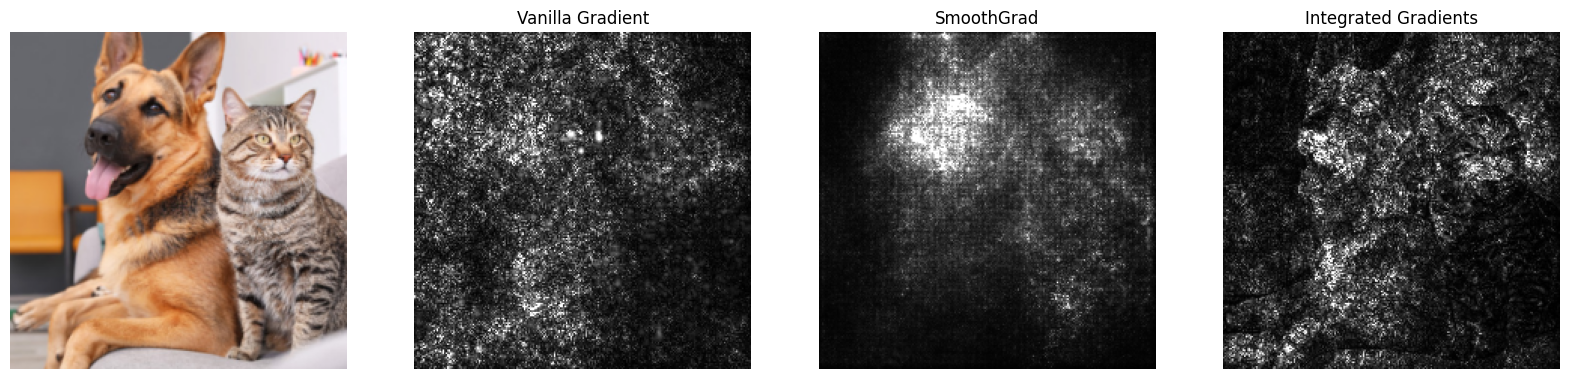

In [ ]:
saliency_map = grad_to_image(attributions_ig)

# Set up matplot lib figures.
plt.rcParams["figure.figsize"] = (20, 5)

plt.subplot(1, 4, 1)
plt.imshow(img_arr)
plt.axis('off')

ShowGrayscaleImage(
    vanilla_mask_grayscale,
    title='Vanilla Gradient',
    ax=P.subplot(1, 4, 2)
)
ShowGrayscaleImage(
    smoothgrad_mask_grayscale,
    title='SmoothGrad',
    ax=P.subplot(1, 4, 3)
)
ShowGrayscaleImage(
    saliency_map,
    title='Integrated Gradients',
    ax=P.subplot(1, 4, 4)
)

Пакет [captum](https://captum.ai/docs/attribution_algorithms) можно использовать и для других модальностей данных, например, для [NLP BERT](https://captum.ai/tutorials/Bert_SQUAD_Interpret2). Там реализовано большое количество модификаций алгоритма Integrated Gradients и не только.

## Grad-CAM

Развитием градиентных методов для сверточных нейронных сетей **CNN** является метод **Grad-CAM** (Class activation maps).

### Идея метода

После каждого **сверточного слоя** нейронной сети мы получаем **карты признаков**, сохраняющие информацию о **расположении объектов** на исходном изображении. При этом все значения признаков для одного канала получаются одним и тем же преобразованием исходного изображения (получаются применением одинаковых сверток с одинаковыми весами), то есть **один канал** — это **карта одного признака**.

 Посмотрим на карты признаков для **ResNet18**. Для этого загрузим модель вместе с весами.

In [ ]:
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Нам интересны сложные признаки, которые выделяются на последних сверточных слоях. ResNet18 был обучен на ImageNet с размерами входного изображения $224\times224$. Посмотрим на размеры на выходе последнего сверточного слоя.

In [ ]:
from torchsummary import summary

summary(model.to("cpu"), (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

На последнем сверточном слое получаем $512$ каналов $7\times7$. Для их сохранения напишем hook, в котором будем сохранять значения активации на выходе модели.


In [ ]:
from collections import defaultdict


def get_forward_hook(history_dict, key):
    def forward_hook(self, input_, output):
        history_dict[key] = output.detach().clone()

    return forward_hook

def register_model_hooks(model):
    hooks_data_history = defaultdict(list)
    forward_hook = get_forward_hook(hooks_data_history, "feature_map")
    model._modules["layer4"].register_forward_hook(forward_hook)
    return hooks_data_history

Предобработаем картинку: приведем к размеру $224\times224$ и нормализуем изображение в соответствии со статистикой ImageNet.

In [ ]:
img_t = get_input_tensors(img)

Пропустим картинку через сеть и сохраним значения активаций.

In [ ]:
model = model.eval()
history = register_model_hooks(model)
output = model(img_t)

print(history["feature_map"].shape)

torch.Size([1, 512, 7, 7])


Нарисуем первые 6 карт признаков. Чтобы растянуть карты по размеру изображения, используем `extent` и `interpolation='bilinear'`.

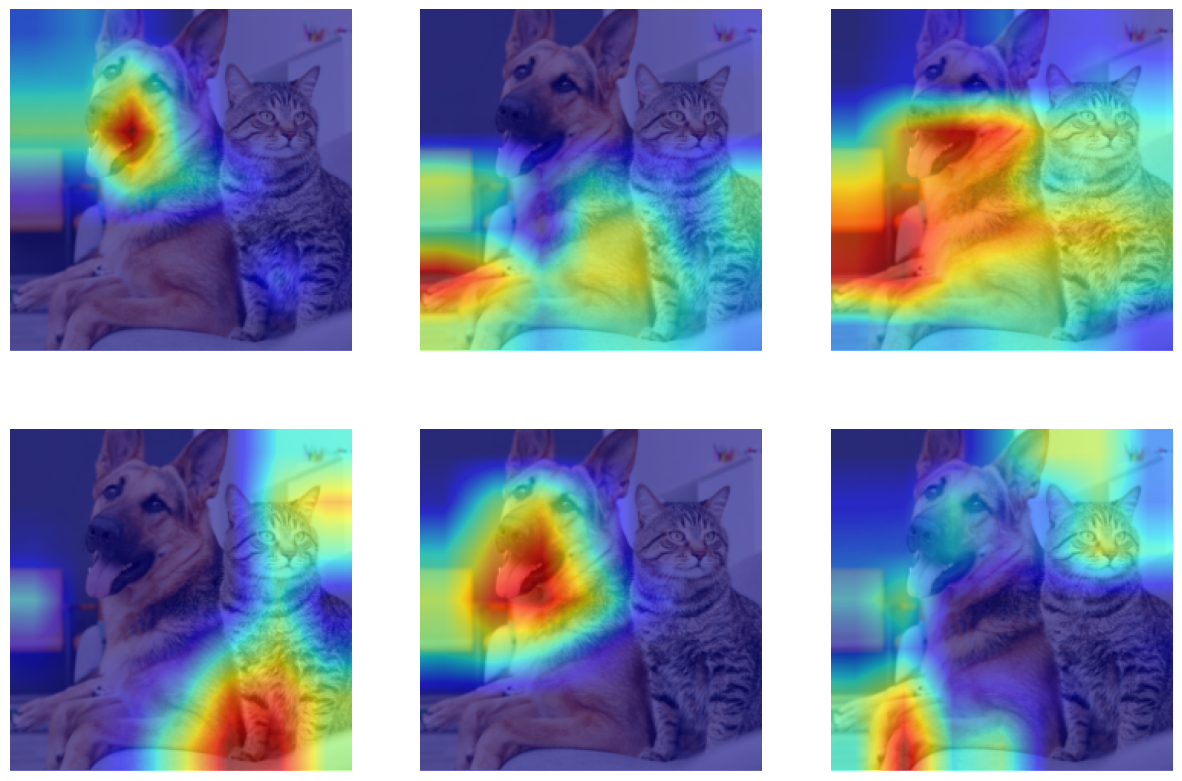

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.ravel()
for i in range(6):
    axs[i].imshow(img_arr)
    axs[i].imshow(
        history["feature_map"][0][i],
        alpha=0.6,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="jet",
    )
    axs[i].axis("off");

Вспомним предсказание модели.

In [ ]:
import torch.nn.functional as F

number_of_top_classes = 6

prediction = F.softmax(output, dim=1)
top_props, top_inds = prediction.topk(number_of_top_classes)


for i in range(number_of_top_classes):
    category_name = idx2label[top_inds[0][i].item()]
    score = top_props[0][i].item()
    print(f"{category_name} {top_inds[0][i].item()}: {100 * score:.1f}%")

German_shepherd 235: 39.4%
tabby 281: 5.4%
tiger_cat 282: 3.3%
space_heater 811: 2.8%
Egyptian_cat 285: 2.2%
hamper 588: 1.4%


Мы смогли понять, к какой части изображения относятся те или иные признаки. Теперь попробуем понять, как они соотносятся с классом. Мы помним, что градиент указывает направление возрастания функции. Если мы выберем логит, соответствующий метке класса, и посчитаем для него градиент, то мы сможем увидеть, какие признаки имеют положительные значения (при их увеличении модель будет больше уверена в оценке).

Напишем хук для сохранения значения градиента. Мы смотрим значения градиента на выходе слоя перед `AdaptiveAvgPool2d`, поэтому сохраним только средние значения (значение градиента для карт признаков одного канала будет одинаковым).

In [ ]:
def get_backward_hook(history_dict, key):
    def backward_hook(self, grad_input_, grad_output):  # for tensors
        history_dict[key] = grad_output[0].detach().clone().mean(
            dim=[2, 3],
            keepdim=True
        )
    return backward_hook


def register_model_hooks(model):
    hooks_data_history = defaultdict(list)

    forward_hook = get_forward_hook(hooks_data_history, "feature_map")
    model._modules["layer4"].register_forward_hook(forward_hook)

    backward_hook = get_backward_hook(hooks_data_history, "weight")
    model._modules["layer4"].register_full_backward_hook(backward_hook)
    return hooks_data_history

Итоговая формула **Grad-CAM** (Class activation maps):

$$\large CAM = ReLU(\sum_{i=1}^{Nch}w_iA_i),$$

где $A_i$ — каналы карты признаков, $w_i$ — веса, полученные пропусканием градиента по логиту, соответствующему метке класса. $ReLU$ используется потому, что нам интересны только положительно влияющие на метку класса признаки.

Функция, рассчитывающая CAM

In [ ]:
def get_cam_map(model, img, class_num):
    history = register_model_hooks(model)

    output = model.eval()(img)
    activation = history["feature_map"]

    output[0, class_num].backward()
    weight = history["weight"]

    cam_map = F.relu((weight[0] * activation[0]).sum(0)).detach().cpu()
    return cam_map

Визуализация важности признаков для top6 классов.

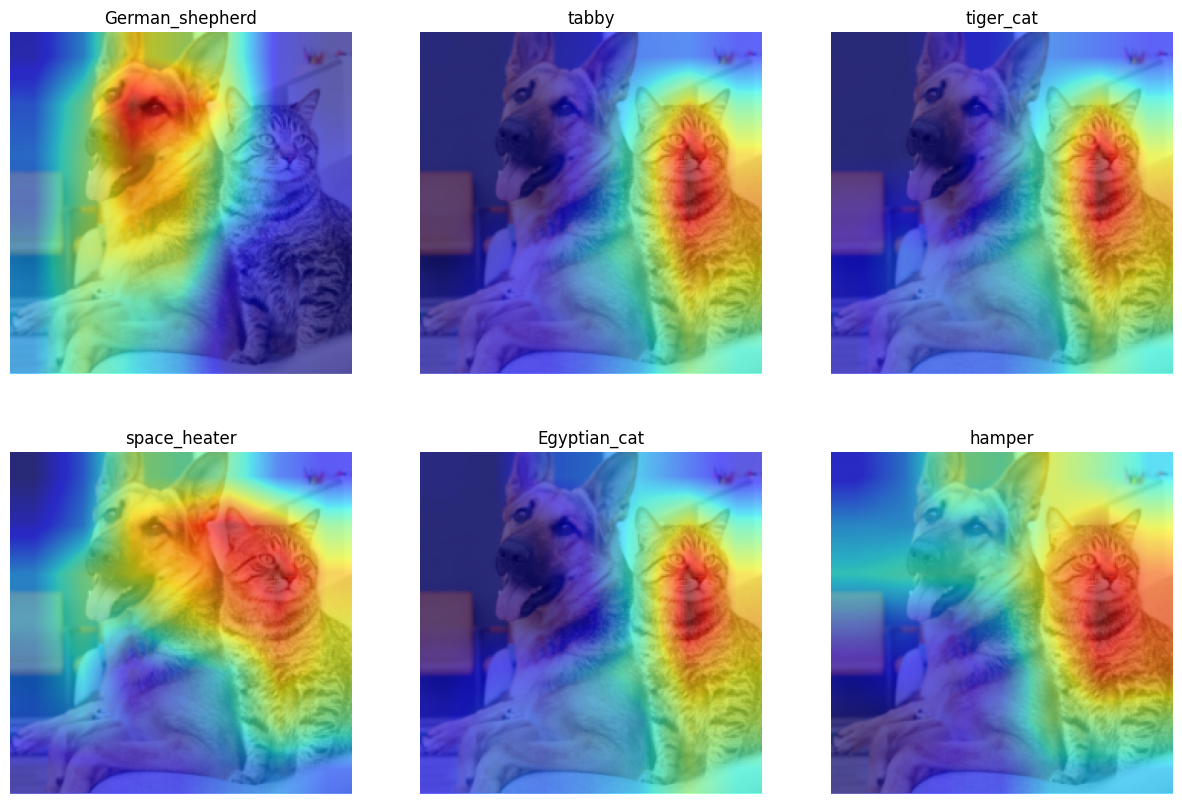

In [ ]:
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
fif, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.ravel()
for i in range(6):
    cam_map = get_cam_map(model, img_t, top_inds[0][i])

    axs[i].imshow(img_arr)
    axs[i].imshow(
        cam_map,
        alpha=0.6,
        extent=(0, 224, 224, 0),
        interpolation="bilinear",
        cmap="jet",
    )
    axs[i].set_title(idx2label[top_inds[0][i].item()])
    axs[i].axis("off");

###Пример изображения (ResNet18)

Можно сделать все то же самое с помощью библиотеки  Grad-CAM.

In [ ]:
from IPython.display import clear_output

!pip install grad-cam
clear_output()

In [ ]:
from pytorch_grad_cam import GradCAM

target_layers = [model._modules["layer4"]]

cam = GradCAM(model=model, target_layers=target_layers)

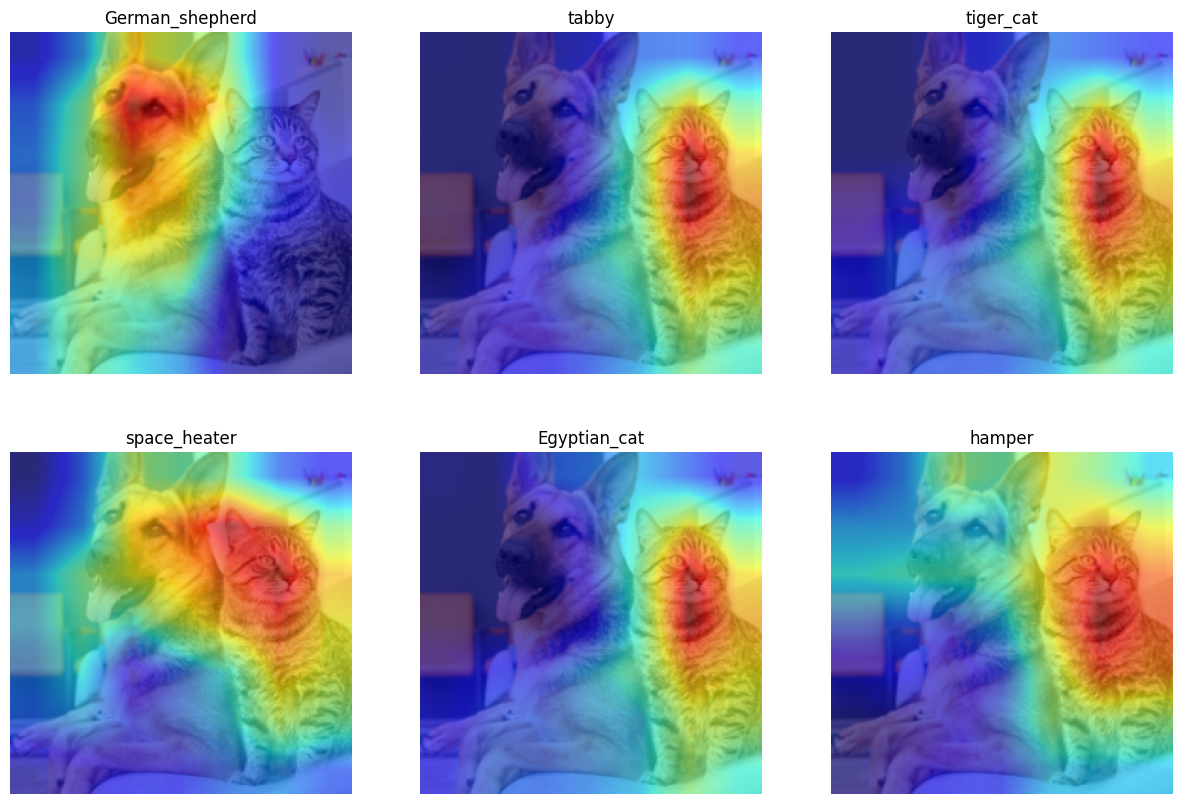

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.ravel()
for i in range(6):
    target = [ClassifierOutputTarget(top_inds[0][i])]
    cam_map = cam(input_tensor=img_t, targets=target)

    axs[i].imshow(img_arr)
    axs[i].imshow(cam_map[0], alpha=0.6, interpolation="bilinear", cmap="jet")
    axs[i].set_title(idx2label[top_inds[0][i].item()])
    axs[i].axis("off");

В библиотеке также реализованы другие методы визуализации, например, Grad-CAM++, использующий градиенты второго порядка.

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus

target_layers = [model._modules["layer4"]]
cam_plus = GradCAMPlusPlus(model=model, target_layers=target_layers)

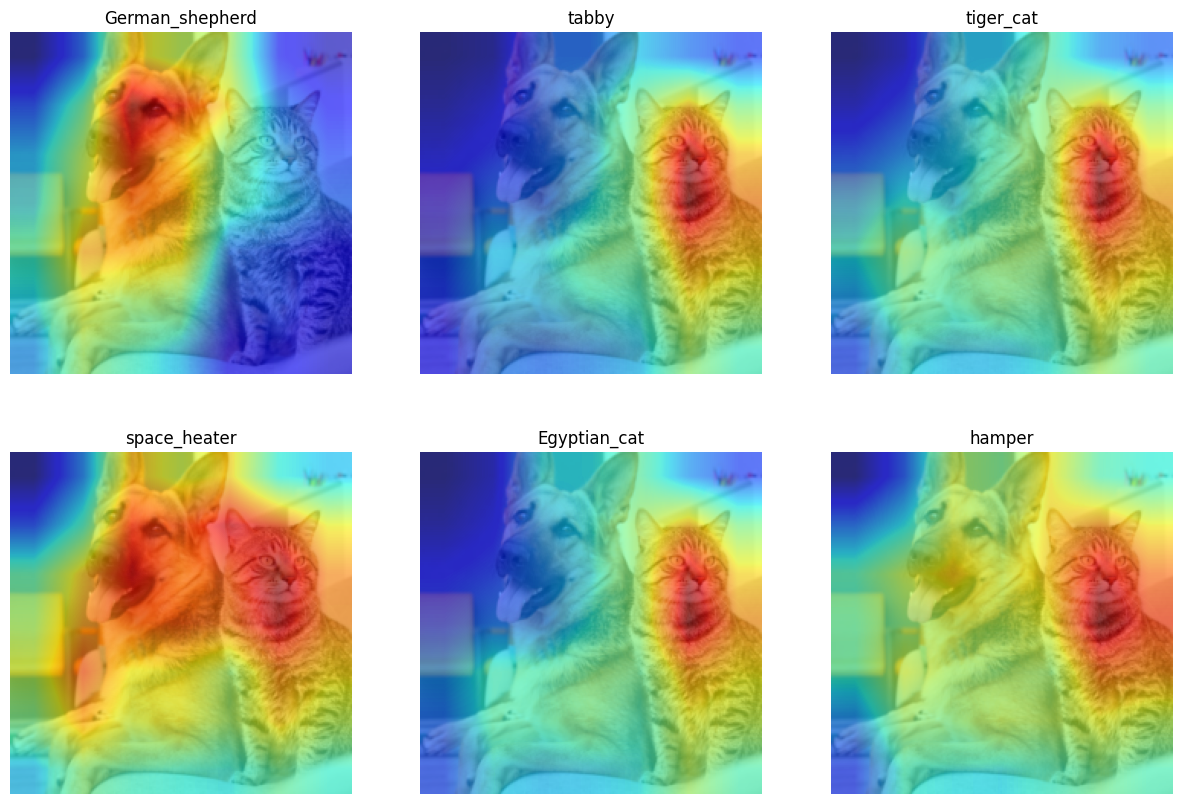

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.ravel()
for i in range(6):
    target = [ClassifierOutputTarget(top_inds[0][i])]
    cam_map = cam_plus(input_tensor=img_t, targets=target)

    axs[i].imshow(img_arr)
    axs[i].imshow(cam_map[0], alpha=0.6, interpolation="bilinear", cmap="jet")
    axs[i].set_title(idx2label[top_inds[0][i].item()])
    axs[i].axis("off");

Grad-CAM++ для ряда изображений работает лучше Grad-CAM.

<center><img src="https://edunet.kea.su/repo/EduNet-additions/GM/grad_cam++.png" alt="alttext" width=600/></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1710.11063.pdf">Grad-CAM++: Improved Visual Explanations for
Deep Convolutional Networks</a></em></center>

Подробнее о других методах читайте в [документации Grad-Cam](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html).

## Критика градиентных методов

Градиентные методы имеют существенное преимущество перед SHAP и LIME: они вычисляются быстрее, чем методы, не зависящие от моделей. Недостаток в том, что в статьях, где предлагались такие методы, **качество работы оценивалось визуально**, “на глаз”.

Хорошим примером проблемы визуальной оценки является метод **Guided Backpropagation**, описанный в [статье](https://arxiv.org/pdf/1412.6806.pdf). Объяснение метода и код можно найти по [ссылке](https://leslietj.github.io/2020/07/22/Deep-Learning-Guided-BackPropagation/).

<center><img src="https://edunet.kea.su/repo/EduNet-additions/GM/guided_backpropagation.png" alt="alttext" width="600"/></center>

<center><em>Картинка получена применением модели ResNet18 и Guided Backpropagation</em></center>

Интуитивно нам кажется, что **Guided Backpropagation** дает хорошее объяснение работы модели, потому что она выделяет границы, по которым легко узнать объект. В статье [Sanity Checks for Saliency Maps](https://arxiv.org/pdf/1810.03292.pdf) показано, что данный метод инвариантен к рандомизации весов верхних слоев модели, что ставит под сомнения его способности объяснения работы модели (во многом он работает как детектор границ).

<center><img src="https://edunet.kea.su/repo/EduNet-additions/GM/guided_backprop_demo.png" alt="alttext" width="900"/></center>

<center><em>Показан результат Guided Backpropagation  при рандомизации слоев в модели Inception v3, начиная с последнего.

Source: <a href="https://arxiv.org/pdf/1810.03292.pdf">Sanity Checks for Saliency Maps.</a></em></center>



В статье [Interpretation of Neural Networks is Fragile](https://arxiv.org/abs/1710.10547) было показано, что небольшое случайное возмущение, добавленное к картинке, не влияющее на результат предсказания, может существенно поменять карты важности, что является спорной критикой, потому что на результат работы нейросети такое возмущение тоже может повлиять.

<center><img src="https://edunet.kea.su/repo/EduNet-additions/GM/criticism_grad_1.png" alt="alttext" width=500/></center>

<center><em>Source: <a href="https://arxiv.org/abs/1710.10547">Interpretation of Neural Networks is Fragile</a></em></center>

В целом [остается проблема](https://arxiv.org/pdf/1912.01451.pdf) оценки качества Saliency Maps. Используйте их с осторожностью.